# **Machine Learning in Finance**

## **Introduction to Graph Neural Networks**

### **Loading Packages**

In [ ]:
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

### **Accessing the data**

**Step 1:**  Download the elliptic dataset from the Kaggle website: https://www.kaggle.com/ellipticco/elliptic-data-set.

**Step 2:** Create a folder for the data on your google drive, e.g., ```/My Drive/Data```, and place the downloaded files from step 1 there.

**Step 3:** In the same folder, add the two files (```GCN_W0.pt``` and ```GCN_W1.pt```) that are provided with the class materials.

**Step 4:** Mount your google drive in the notebook by executing the cell below. Follow the verification procedure.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 5:** Read the files of the dataset in the notebook by executing the cell below. Modify the path to the location of the data on your drive.

In [ ]:
import pandas as pd

path = '/content/drive/Mon Drive/data/elliptic_bitcoin_dataset/'
features_raw = pd.read_csv(path+'elliptic_txs_features.csv').to_numpy()
edgelist_raw = pd.read_csv(path+'elliptic_txs_edgelist.csv', header=None, skiprows=[0]).to_numpy()
classes_raw = pd.read_csv(path+'elliptic_txs_classes.csv', header=None, skiprows=[0]).to_numpy()

print('Data import done.')

FileNotFoundError: ignored

### **Preparing the data**


The the dataset contains 203,769 **nodes**, representking Bitcoin transactions and 234,355 (directed) **edges**, indicating the flow of Bitcoin from one transaction to another. Among the nodes, 2\% (4,545) are labelled as **illicit** (class 1), while 21\% (42,019) are labelled as **licit** (class 2). The remaining transactions are unlabelled (class 'unknown').

At each node, we are given 166 node **features**. The first 94 features represent local information about the transaction, e.g., number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained by aggregating
transaction information one-step backward/forward from the center node. More details can be found in *Weber and Domeniconi, et al.*

The elliptic dataset has a **temporal structure** with data collected at 49 subsequent time steps (indicated in the first column of the array ```features_raw```). No edges exist between different time steps. Therefore, we choose to split the dataset according to the different time steps.

As in the paper, we adopt a temporal train/test split, using the first 34 timesteps for training, and the last 15 timesteps for testing.

**Important:** The preprocessing of the data and the training of the model are time-consuming when run with limited computational recources.

**Therefore, we provide pretrained weights for the model and only perform the test step here.**

Executing the following cell will preprocess the 15 timesteps that are used for model testing with the corresponding adjacency matrices, node featurs and node labels. Note that we only consider labelled nodes (and edges that are supported on them).



In [ ]:
## split data into connected components
node_classes = classes_raw[classes_raw[:,1] != 'unknown'] # exclude label 'unkonwn'
timesteps = features_raw[:,1] # timesteps are maintained in the second row of features_raw

## establish test set
test_features_list = []
test_labels_list = []
test_adjacency_list = []

for ts in range(35,50):
    features = features_raw[timesteps == ts] # find features for selected timestep
    nodes = features[:,0] # find nodes for selected timestep
    labelled_index = [True if node in node_classes[:,0] else False for node in nodes] # find indices of labelled nodes
    labelled_nodes = nodes[labelled_index] # find labelled nodes
    test_features_list.append(features[labelled_index][:,1:])
    labels = [node_classes[:,1][list(node_classes[:,0]).index(node)] for node in labelled_nodes] # find node labels
    test_labels_list.append(np.array([label=='1' for label in labels], dtype=int))
    edge_indices = [True if edge[0] in labelled_nodes and edge[1] in labelled_nodes  else False for edge in list(map(list, edgelist_raw))] # only select edges that are supported on labelled nodes
    edgelist = edgelist_raw[edge_indices]
    
    G = nx.Graph()
    G.add_nodes_from(labelled_nodes)
    G.add_edges_from(edgelist)

    test_adjacency_list.append(nx.adjacency_matrix(G).toarray())

print('Data preparation done.')

Data preparation done.


### **GCN Model**

As proposed in *Weber and Domeniconi, et al.*, we implement a **two-layer GCN** model for the task of **detecting illicit Bitcoin transactions**. The model has the form:

$$
\operatorname{two\_layer\_GCN}\left(\mathbf{X}, \mathbf{A}) = \operatorname{softmax} (\mathbf{A} \cdot \operatorname{ReLU}(\mathbf{A} \mathbf{X} \mathbf{W}_0) \cdot \mathbf{W}_1\right)
$$

Further details can be found in *Weber and Domeniconi, et al.* https://arxiv.org/abs/1908.02591.

#### **Implementation**

In [1]:
def diffusion_matrix(adj):
    """Diffusion matrix for GCN layer
     
    Input: adj (torch.Tensor): adjacency matrix
    Output: A (torch.Tensor): diffusion matrix
    """
    
    # add self loops to adjacency matrix
    adj_ = torch.add(adj, torch.eye(adj.shape[0]).double())
    
    # derive degree matrix
    D = torch.diag(adj_.sum(1))
    
    # take square root and derive inverse
    D_root_inv = torch.inverse(torch.sqrt(D))
    
    # normalize the adjacency matrix
    A = torch.mm(torch.mm(D_root_inv, adj_), D_root_inv)
    
    return A

In [2]:
class GCN_layer(nn.Module):
    """Simple GCN layer"""
    
    def __init__(self, d_in, d_out):
        super(GCN_layer, self).__init__()
        self.weight = torch.nn.Parameter(torch.DoubleTensor(d_in, d_out))
        nn.init.xavier_uniform_(self.weight)
            
    def forward(self, X, A, activation=None):
        
        # feature transformation        
        output = torch.mm(X, self.weight)        
        
        # feature aggregation
        output = torch.mm(A, output)
        
        # nonlinear activation
        if activation=='relu':
            output = F.relu(output)
        elif activation=='softmax':
            output = F.softmax(output, dim=1)
        else:
            raise ValueError("No nonlinear activation specified")
                
        return output

NameError: ignored

In [ ]:
class two_layer_GCN(nn.Module):
    """Two-layer GCN model

    Args:
        d_in (int): number of input node features of model
        d_hidden (int): number of neurons in hidden layer
        d_out (int): number of classes
    """

    def __init__(self, d_in, d_hidden, d_out):
        super(two_layer_GCN, self).__init__()
        
        self.layer_one = GCN_layer(d_in, d_hidden)
        self.layer_two = GCN_layer(d_hidden, d_out)
    
    def forward(self, X, A):
        output = self.layer_one(X, A, 'relu')
        output = self.layer_two(output, A, 'softmax')
    
        return output

**Important:** We have provided the evaluation procedure below. In order to make use of it, your model should take a node feature matrix $\mathbf{X}$ and a diffusion matrix $\mathbf{A}$ as input for the forward pass.

#### **Testing Procedure**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(model, features_list, adjacency_list, labels_list):
    
    # derivation of scores (by time step)
    L_pred_list = []
    prec_list = []
    recall_list = []
    f1_list = []
    f1_micro_list = []
        
    for i in range(15):
        X = torch.tensor(features_list[i])[:,:num_features]
        A = diffusion_matrix(torch.tensor(adjacency_list[i]))
        L = torch.tensor(labels_list[i], dtype = torch.long)

        model.eval()
        out = model(X, A)

        L_pred = out.max(1)[1].type_as(L)
        
        L_pred_list.append(L_pred)
        prec_list.append(precision_score(L, L_pred, average='binary'))
        recall_list.append(recall_score(L, L_pred, average='binary'))
        f1_list.append(f1_score(L, L_pred, average='binary'))
        f1_micro_list.append(f1_score(L, L_pred, average='micro'))

    # derivation of global scores (across time steps)
    global_L = np.concatenate(labels_list)
    global_L_pred = np.concatenate(L_pred_list)

    global_prec = precision_score(global_L, global_L_pred, average='binary')
    global_recall = recall_score(global_L, global_L_pred, average='binary')
    global_f1 = f1_score(global_L, global_L_pred, average='binary')
    global_f1_micro = f1_score(global_L, global_L_pred, average='micro')

    # store everything in dictionary
    metrics = {}
    metrics['global_prec'] = global_prec
    metrics['global_recall'] = global_recall
    metrics['global_f1'] = global_f1
    metrics['global_f1_micro'] = global_f1_micro

    metrics['prec_list'] = prec_list
    metrics['recall_list'] = recall_list
    metrics['f1_list'] = f1_list
    metrics['f1_micro_list'] = f1_micro_list

    print(f'Global precision: {np.round(global_prec, 3)} (expected result: {0.907})')
    print(f'Global recall: {np.round(global_recall, 3)} (expected result: {0.507})')
    print(f'Global F1: {np.round(global_f1, 3)} (expected result: {0.65})')
    print(f'Global F1 (micro average): {np.round(global_f1_micro, 3)} (expected result: {0.965})')

    return metrics

#### **Testing**

In [ ]:
num_features = 166
num_hidden = 100
num_classes = 2

model = two_layer_GCN(num_features, num_hidden, num_classes)

# load pretrained weight matrices
W0 = torch.load(path+'GCN_W0.pt')
W1 = torch.load(path+'GCN_W1.pt')

# replace weight matrices of your model by pretrained ones
model.layer_one.weight = W0
model.layer_two.weight = W1

In [ ]:
metrics = evaluate_model(model, test_features_list, test_adjacency_list, test_labels_list)

Global precision: 0.907 (expected result: 0.907)
Global recall: 0.507 (expected result: 0.507)
Global F1: 0.65 (expected result: 0.65)
Global F1 (micro average): 0.965 (expected result: 0.965)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Dark Market Shutdown**

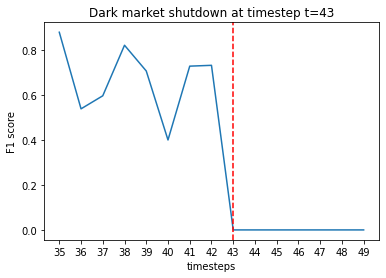

In [ ]:
ax = plt.subplot()
ax.plot(range(35,50), metrics['f1_list'])
ax.set_title('Dark market shutdown at timestep t=43')
ax.set_xticks(np.arange(35,50))
ax.axvline(x=43, color='r', linestyle='--')
ax.set_xlabel('timesteps')
ax.set_ylabel('F1 score')
plt.show()